# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT vs QTransform with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1}$, $Cole\;Welch^{1}$, $Arif\;Chu^{1}$, $Chia-Jui\;Chou^{2}$, $Andy\;Chen^{2}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle,\;USA$; $^{2}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py 
import torch
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch import nn
from pyts.image import GramianAngularField
from tqdm import tqdm

from gasf.utils import h5_thang
from gasf.sampling import *
import ml4gw


## Old packages that are not currently used ##
# import pandas as pd
# import seaborn as sns
# from scipy import signal
# from gwpy.timeseries import TimeSeries
# from gwpy.signal import filter_design
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from timeit import default_timer as timer

# from tqdm.notebook import trange

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## TESTING

### Loading all of the files

In [3]:
signalsFilename = '/home/dfredin/gwgasf/data/BBH_project.h5'
testFilename = '/home/dfredin/gwgasf/data/classify_data.h5'


H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262473216-4096.hdf5'
# H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262481408-4096.hdf5'
# H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262489600-4096.hdf5'
# H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262493696-4096.hdf5'
# H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262497792-4096.hdf5'
# H1strainFilename = '/home/dfredin/gwgasf/data/H1/H-H1_GWOSC_O3b_4KHZ_R1-1262505984-4096.hdf5'

# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262473216-4096.hdf5'
# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262481408-4096.hdf5'
# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262489600-4096.hdf5'
# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262493696-4096.hdf5'
# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262497792-4096.hdf5'
# L1strainFilename = '/home/dfredin/gwgasf/data/L1/L-L1_GWOSC_O3b_4KHZ_R1-1262505984-4096.hdf5'



meta
quality
strain

Description b'Strain data time series from LIGO'
DescriptionURL b'http://www.gw-openscience.org/'
Detector b'H1'
Duration 4096
FrameType b'H1_HOFT_CLEAN_SUB60HZ_C01'
GPSstart 1262473216
Observatory b'H'
StrainChannel b'H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01'
Type b'StrainTimeSeries'
UTCstart b'2020-01-07T22:59:58'


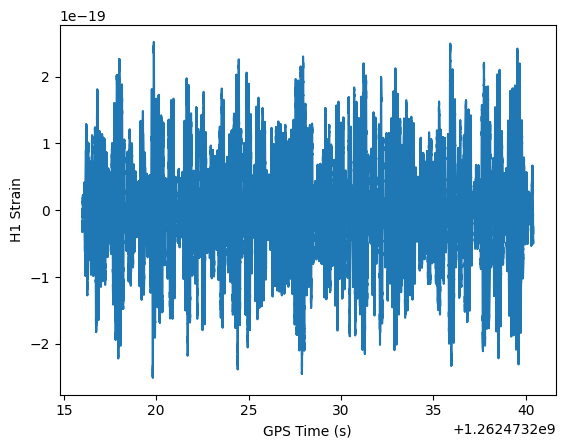

In [4]:
strainDataFile = h5py.File(H1strainFilename, 'r')

for key in strainDataFile.keys():
    print(key)

strain = strainDataFile['strain']['Strain']
ts = strainDataFile['strain']['Strain'].attrs['Xspacing']

print()

metaKeys = strainDataFile['meta'].keys()
meta = strainDataFile['meta']
for key in metaKeys:
    print(key, meta[key][()])


gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, ts)


numSamples = 100000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()


strainDataFile.close()
# strain_test = strain_info.h5_data()['meta']['GPSstart'][()]

In [4]:
H1strainFilename
strain_info = h5_thang(H1strainFilename)
strain_keys = strain_info.h5_keys()

In [5]:
signal_info = h5_thang(signalsFilename)
signal_keys = signal_info.h5_keys()

signal_bbh_H1 = signal_info.h5_data()['waveforms_H1']
signal_bbh_L1 = signal_info.h5_data()['waveforms_L1']

In [6]:
signals = np.stack([signal_bbh_H1, signal_bbh_L1], axis=1)
signals.shape

(11630, 2, 32768)

In [7]:
strain_keys

['meta/Description',
 'meta/DescriptionURL',
 'meta/Detector',
 'meta/Duration',
 'meta/FrameType',
 'meta/GPSstart',
 'meta/Observatory',
 'meta/StrainChannel',
 'meta/Type',
 'meta/UTCstart',
 'quality/injections/GWOSCmeta',
 'quality/injections/InjDescriptions',
 'quality/injections/InjShortnames',
 'quality/injections/Injmask',
 'quality/simple/DQDescriptions',
 'quality/simple/DQShortnames',
 'quality/simple/DQmask',
 'quality/simple/GWOSCmeta',
 'strain/GWOSCmeta',
 'strain/Strain']

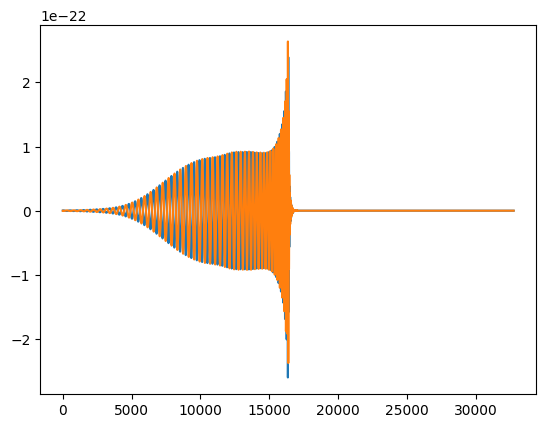

In [18]:
x = np.arange(0, 32768, 1)
y = signals[449,0,:]
y2 = signals[449,1,:]

plt.plot(x,y)
plt.plot(x,y2)
plt.show()

# Preparing the data

In [5]:
### -------------Load dataset------------- ###

# Define the file name
filename = '/home/dfredin/gwgasf/data/classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


# Define the file name
filename = '/home/dfredin/gwgasf/data/overlap.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    overlap = np.array(file['overlap'])
    overlap_train = overlap[:-299]
    overlap_val = overlap[-299:]


## ---------------- ONE-HOT ENCODING ----------------------------##

# NOTE: 
# Multiclassifier
anomaly_class = {
    'Glitch': [1, 0, 0],
    'Signal': [0, 1, 0],
    'Overlap': [0, 0, 1]
}

In [6]:

x_train = np.concatenate((glitch_train, bbh_train, overlap_train), axis=0).transpose((0,2,1))

x_val = np.concatenate((glitch_val, bbh_val, overlap_val), axis=0).transpose((0,2,1))


# ID our data as background, signal or overlap

glitch_train_ids = np.full((glitch_train.shape[0], 3), anomaly_class['Glitch'])
bbh_train_ids = np.full((bbh_train.shape[0], 3), anomaly_class['Signal'])
overlap_train_ids = np.full((overlap_train.shape[0], 3), anomaly_class['Overlap'])

y_train = np.concatenate((glitch_train_ids, bbh_train_ids, overlap_train_ids), axis=0)

glitch_val_ids = np.full((glitch_val.shape[0], 3), anomaly_class['Glitch'])
bbh_val_ids = np.full((bbh_val.shape[0], 3), anomaly_class['Signal'])
overlap_val_ids = np.full((overlap_val.shape[0], 3), anomaly_class['Overlap'])

y_val = np.concatenate((glitch_val_ids, bbh_val_ids, overlap_val_ids), axis=0)


del glitch_train, bbh_train, overlap_train, glitch_val, bbh_val, overlap_val
del glitch_train_ids, bbh_train_ids, overlap_train_ids, glitch_val_ids, bbh_val_ids, overlap_val_ids

In [7]:
### -------------Split detector dataset------------- ###

# x_train_dec1 = x_train[:,:,0]
# x_train_dec2 = x_train[:,:,1]

# x_val_dec1 = x_val[:,:,0]
# x_val_dec2 = x_val[:,:,1]


# print(f'validation:{len(y_val)}')
n_train = 10000
n_val = 2000

# Generate the idx_train, idx_val to randomly sample from the training set and validation set.
idx_train = np.random.randint(0, len(x_train), size=n_train)
idx_val = np.random.randint(0, len(x_val), size=n_val)

x_train_dec1 = x_train[idx_train,:,0]
x_train_dec2 = x_train[idx_train,:,1]

y_train = y_train[idx_train]

x_val_dec1 = x_val[idx_val,:,0]
x_val_dec2 = x_val[idx_val,:,1]

y_val = y_val[idx_val]

### -------------GASF CONVERSION------------- ###

GASF = GramianAngularField(image_size=194, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = GASF.transform(x_train_dec1)
img_x_train_dec2 = GASF.transform(x_train_dec2)
del x_train_dec1, x_train_dec2

# Convert testing data to image format
img_x_val_dec1 = GASF.transform(x_val_dec1)
img_x_val_dec2 = GASF.transform(x_val_dec2)
del x_val_dec1, x_val_dec2

In [8]:

# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
img_x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
del img_x_train_dec1, img_x_train_dec2
img_x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)
del img_x_val_dec1, img_x_val_dec2

img_y_val = y_val

### -------------Split into training and validation datasets------------- ###

## NOTE: MAYBE USER INPUT FOR SPLIT %???

# Take the first 17.65% of our training features and targets as validation set
img_x_test= img_x_train[:round((len(img_x_train)*0.12))]
img_y_test = y_train[:round((len(y_train)*0.12))]

# Take the remaining 82.35% of training features and targets as training set
img_x_train = img_x_train[round((len(img_x_train)*0.12)):]
img_y_train = y_train[round((len(y_train)*0.12)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 85%, 12%, 3% split.
print("X Training Shape: ", img_x_train.shape)
print("Y Training Shape: ", img_y_train.shape)
print("X Testing Shape: ", img_x_test.shape)
print("Y Testing Shape: ", img_y_test.shape)
print("X Validation Shape: ", img_x_val.shape)
print("Y Validation Shape: ", img_y_val.shape)

X Training Shape:  (8800, 2, 194, 194)
Y Training Shape:  (8800, 3)
X Testing Shape:  (1200, 2, 194, 194)
Y Testing Shape:  (1200, 3)
X Validation Shape:  (2000, 2, 194, 194)
Y Validation Shape:  (2000, 3)


In [9]:

strains = [img_x_train, img_x_val, img_x_test]

# strains = [training_strain, validation_strain, testing_strain]

targets = [img_y_train, img_y_val, img_y_test]

# targets = [training_targets, validation_targets, testing_targets]

## DataLoader

In [10]:
class MyDataset(Dataset):

    def __init__(self, data, target, ifos=3, kernel_size=4096):

        # Get data type from https://pytorch.org/docs/stable/tensors.html
        # self.data = torch.FloatTensor(
        #     data.reshape([-1, ifos, kernel_size])
        # )
        # 
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(target)
    
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        return x, y

In [11]:
# Load Training data into pytorch tensor
dataset = MyDataset(strains[0], targets[0])

training_data = DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True
)

# Load Validation data into pytorch tensor
dataset_v = MyDataset(strains[1], targets[1])
validation_data = DataLoader(
    dataset_v, 
    batch_size=32, 
    shuffle=True
)

# Load Validation data into pytorch tensor
dataset_t = MyDataset(strains[2], targets[2])
testing_data = DataLoader(
    dataset_t, 
    batch_size=32, 
    shuffle=True
)

## CNN Model

In [12]:

               ## # | 64 x 64 | 127 x 127 | 194 x 194 |
cnn1In = 2     ## # |    2    |     2     |     2     |
cnn1Out = 64   ## # |    16   |     16    |     16    |    
cnn1K = 6      ## # |    4    |     5     |     6     |
cnn1S = 2      ## # |    2    |     2     |     2     |
cnn1P = 1      ## # |    1    |     2     |     1     |
batch1 = 64    ## # |    16   |     16    |     16    |
max1K = 5      ## # |    4    |     2     |     5     |
max1S = 3      ## # |    2    |     2     |     3     |
max1P = 1      ## # |    1    |     0     |     1     |

cnn2In = 64    ## # |    16   |     16    |     16    |
cnn2Out = 128   ## # |    32   |     32    |     32    |
cnn2K = 4      ## # |    3    |     4     |     4     |
cnn2S = 2      ## # |    1    |     2     |     2     |
cnn2P = 1      ## # |    1    |     1     |     1     |
batch2 = 128    ## # |    32   |     32    |     32    |
max2K = 2      ## # |    2    |     2     |     2     |
max2S = 2      ## # |    2    |     2     |     2     |
max2P = 0      ## # |    0    |     0     |     0     |

### -------------194 x 194 Model Definition------------- ###

class CNNModel(nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=cnn1Out, kernel_size=cnn1K, stride=cnn1S, padding=cnn1P),
            nn.ReLU(),
            nn.BatchNorm2d(batch1),
            nn.MaxPool2d(kernel_size=max1K, stride=max1S, padding=max1P)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=cnn2In, out_channels=cnn2Out, kernel_size=cnn2K, stride=cnn2S, padding=cnn2P),
            nn.ReLU(),
            nn.BatchNorm2d(batch2),
            nn.MaxPool2d(kernel_size=max2K, stride=max2S, padding=max2P)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 8 ,8) -> (2048) and output 2 classes
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=3)
        self.dropcnn = nn.Dropout(0.25)
        self.dropfc = nn.Dropout(0.6)

    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        out = self.dropcnn(out)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        out = self.dropcnn(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.dropfc(out)
        out = self.fc2(out)
        out = self.dropfc(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [13]:
  ### -------------Hyperparameters------------- ###

# Initialize the CNN model
GASF_Model = CNNModel().to(device)

# An easy way to give you the outline of your model
summary(GASF_Model,  (2, 194, 194), len(strains[0]))


learning_rate = 0.0005     # 0.00005
epochs = 25                 # 40
# batchsize = 225             # 768
L2_reg = 0.001            # 0.00005

# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    GASF_Model.parameters(), 
    lr = learning_rate, 
    weight_decay=L2_reg)

/home/dfredin/miniconda3/envs/GASF39/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [8800, 64, 96, 96]           4,672
              ReLU-2         [8800, 64, 96, 96]               0
       BatchNorm2d-3         [8800, 64, 96, 96]             128
         MaxPool2d-4         [8800, 64, 32, 32]               0
           Dropout-5         [8800, 64, 32, 32]               0
            Conv2d-6        [8800, 128, 16, 16]         131,200
              ReLU-7        [8800, 128, 16, 16]               0
       BatchNorm2d-8        [8800, 128, 16, 16]             256
         MaxPool2d-9          [8800, 128, 8, 8]               0
          Dropout-10          [8800, 128, 8, 8]               0
           Linear-11               [8800, 1024]       8,389,632
          Dropout-12               [8800, 1024]               0
           Linear-13                [8800, 512]         524,800
          Dropout-14                [88

## Training

In [14]:
cost_value = np.empty(epochs)
cost_valid_value = np.empty(epochs)

for i in range(epochs):
    t_cost = 0
    for j, (x, y) in enumerate(tqdm(training_data, desc=f'Epoch {i+1}')):
        x = x.to(device)
        y = y.to(device)
        # print(y)

        p_value = GASF_Model(x)

        p_value = torch.transpose(p_value,0,1)
        y = torch.transpose(y,0,1)
        # print(p_value)
        y = torch.argmax(y, dim = 1)
        cost = loss_func(p_value, y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
        t_cost += cost.item()

    cost_value[i] = t_cost/(j+1)
        
    print('========')
    print(f'Cost{round(cost_value[i], 2)}')
    print('========', '\n')

    with torch.no_grad():
        v_cost = 0
        for run, (a, b) in enumerate(validation_data):
            a = a.to(device)
            b = b.to(device)
            
            p_value = GASF_Model(a)

            p_value = torch.transpose(p_value,0,1)
            b = torch.transpose(b,0,1)

            b = torch.argmax(b, dim = 1)
            cost_valid = loss_func(p_value, b)
            
            v_cost += cost_valid.item()
            
        cost_valid_value[i] = v_cost/(run+1)
        
        print('===================')
        print(f'Validation Cost{round(cost_valid_value[i], 2)}')
        print('===================', '\n')

Epoch 1: 100%|██████████| 275/275 [00:11<00:00, 23.72it/s]


Cost7.46

Validation Cost5.56



Epoch 2: 100%|██████████| 275/275 [00:11<00:00, 24.08it/s]


Cost4.45

Validation Cost4.57



Epoch 3: 100%|██████████| 275/275 [00:11<00:00, 24.68it/s]


Cost3.6

Validation Cost3.94



Epoch 4: 100%|██████████| 275/275 [00:11<00:00, 24.85it/s]


Cost3.26

Validation Cost3.89



Epoch 5: 100%|██████████| 275/275 [00:10<00:00, 25.20it/s]


Cost3.11

Validation Cost3.47



Epoch 6: 100%|██████████| 275/275 [00:11<00:00, 24.83it/s]


Cost3.0

Validation Cost3.68



Epoch 7: 100%|██████████| 275/275 [00:11<00:00, 24.68it/s]


Cost3.02

Validation Cost3.46



Epoch 8: 100%|██████████| 275/275 [00:10<00:00, 25.18it/s]


Cost3.1

Validation Cost3.45



Epoch 9: 100%|██████████| 275/275 [00:10<00:00, 25.02it/s]


Cost3.06

Validation Cost3.46



Epoch 10: 100%|██████████| 275/275 [00:10<00:00, 25.19it/s]


Cost3.02

Validation Cost3.36



Epoch 11: 100%|██████████| 275/275 [00:10<00:00, 25.19it/s]


Cost3.01

Validation Cost3.94



Epoch 12: 100%|██████████| 275/275 [00:10<00:00, 25.03it/s]


Cost3.15

Validation Cost3.51



Epoch 13: 100%|██████████| 275/275 [00:10<00:00, 25.09it/s]


Cost3.03

Validation Cost3.9



Epoch 14: 100%|██████████| 275/275 [00:10<00:00, 25.17it/s]


Cost3.07

Validation Cost3.52



Epoch 15: 100%|██████████| 275/275 [00:10<00:00, 25.09it/s]


Cost3.11

Validation Cost3.61



Epoch 16: 100%|██████████| 275/275 [00:11<00:00, 24.98it/s]


Cost3.17

Validation Cost3.62



Epoch 17: 100%|██████████| 275/275 [00:11<00:00, 24.94it/s]


Cost3.12

Validation Cost3.67



Epoch 18: 100%|██████████| 275/275 [00:10<00:00, 25.05it/s]


Cost3.07

Validation Cost3.29



Epoch 19: 100%|██████████| 275/275 [00:10<00:00, 25.00it/s]


Cost2.98

Validation Cost3.4



Epoch 20: 100%|██████████| 275/275 [00:10<00:00, 25.09it/s]


Cost3.0

Validation Cost3.63



Epoch 21: 100%|██████████| 275/275 [00:11<00:00, 24.97it/s]


Cost3.12

Validation Cost3.48



Epoch 22: 100%|██████████| 275/275 [00:11<00:00, 24.86it/s]


Cost3.03

Validation Cost3.39



Epoch 23: 100%|██████████| 275/275 [00:11<00:00, 24.91it/s]


Cost3.04

Validation Cost3.56



Epoch 24: 100%|██████████| 275/275 [00:11<00:00, 24.84it/s]


Cost2.93

Validation Cost3.3



Epoch 25: 100%|██████████| 275/275 [00:11<00:00, 24.50it/s]


Cost3.02

Validation Cost3.47



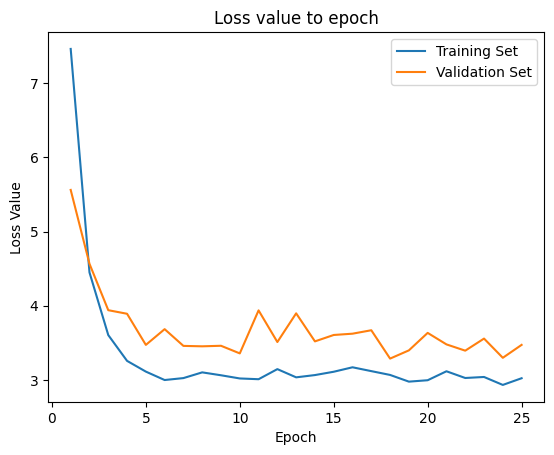

In [15]:
total_epoch = np.linspace(1, epochs, epochs)
plt.title('Loss value to epoch')
plt.plot(total_epoch, cost_value, label = 'Training Set')
plt.plot(total_epoch, cost_valid_value, label = 'Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
# plt.savefig('Loss.png', bbox_inches = 'tight')
plt.show()
plt.close()

-------

## Confusion Matrix Analysis

In [16]:
# torch tensor device check

if device.type == 'cpu':
    dtype = torch.FloatTensor
elif device.type =='cuda':
    dtype = torch.cuda.FloatTensor

100%|██████████| 63/63 [00:00<00:00, 65.70it/s]


tensor([671., 671., 658.], device='cuda:0')


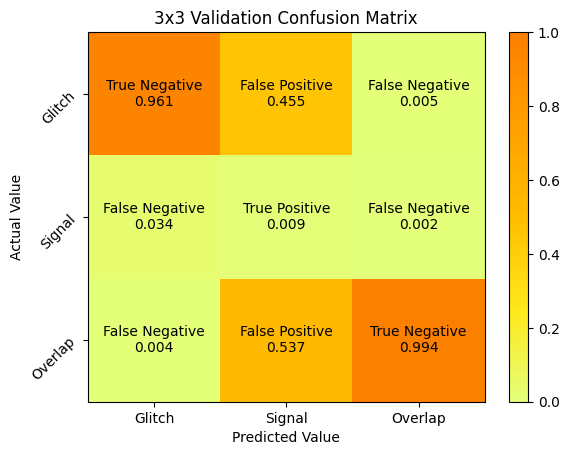

In [17]:
num_classes = 3
conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
num_count = torch.zeros([num_classes]).to(device)

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(validation_data)):
        
        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    print(num_count)
    num_count = num_count.detach().cpu().numpy().astype('float64')
    conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# Normalize the confusion matrix.
conf_matrix /= num_count

# print(conf_matrix)

# TODO Old confusion matrix code, not needed?
# Plotting Scheme
# TPR = conf_matrix[0, 0]
# FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# print(f'TPR: {TPR}')
# print(f'FPR: {FPR}')

# Labels for a 3x3 confusion matrix
lab = np.array([['True Negative', 'False Positive', 'False Negative'], 
                ['False Negative', 'True Positive', 'False Negative'],
                ['False Negative', 'False Positive', 'True Negative']])

plt.figure()
color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# Adjust the loop for a 3x3 matrix
for i in range(3):
    for j in range(3):
        plt.text(i+.5, j+.5, 
                 f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
                 ha='center', 
                 va='center')

# Update the ticks for three classes
plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Overlap'])
plt.yticks([.5, 1.5, 2.5], ['Overlap', 'Signal', 'Glitch'], rotation=45)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('3x3 Validation Confusion Matrix')
# plt.title(
#     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# )
plt.colorbar(color)
# # plt.savefig('Validation set performance.png', bbox_inches = 'tight')
plt.show()
plt.close()


100%|██████████| 275/275 [00:04<00:00, 63.43it/s]


tensor([4064., 3889.,  847.], device='cuda:0')


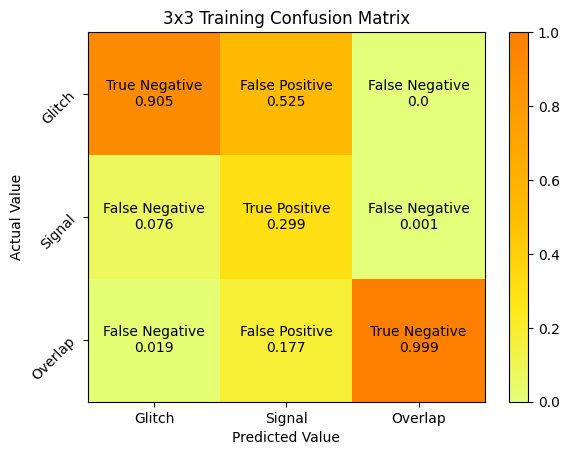

In [18]:
num_classes = 3
conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
num_count = torch.zeros([num_classes]).to(device)

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(training_data)):
        
        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    print(num_count)
    num_count = num_count.detach().cpu().numpy().astype('float64')
    conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# Normalize the confusion matrix.
conf_matrix /= num_count

# print(conf_matrix)

# TODO Old confusion matrix code, not needed?
# Plotting Scheme
# TPR = conf_matrix[0, 0]
# FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# print(f'TPR: {TPR}')
# print(f'FPR: {FPR}')

# Labels for a 3x3 confusion matrix
lab = np.array([['True Negative', 'False Positive', 'False Negative'], 
                ['False Negative', 'True Positive', 'False Negative'],
                ['False Negative', 'False Positive', 'True Negative']])

plt.figure()
color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# Adjust the loop for a 3x3 matrix
for i in range(3):
    for j in range(3):
        plt.text(i+.5, j+.5, 
                 f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
                 ha='center', 
                 va='center')

# Update the ticks for three classes
plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Overlap'])
plt.yticks([.5, 1.5, 2.5], ['Overlap', 'Signal', 'Glitch'], rotation=45)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('3x3 Training Confusion Matrix')
# plt.title(
#     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# )
plt.colorbar(color)
# # plt.savefig('Validation set performance.png', bbox_inches = 'tight')
plt.show()
plt.close()


100%|██████████| 38/38 [00:00<00:00, 61.74it/s]


tensor([538., 540., 122.], device='cuda:0')


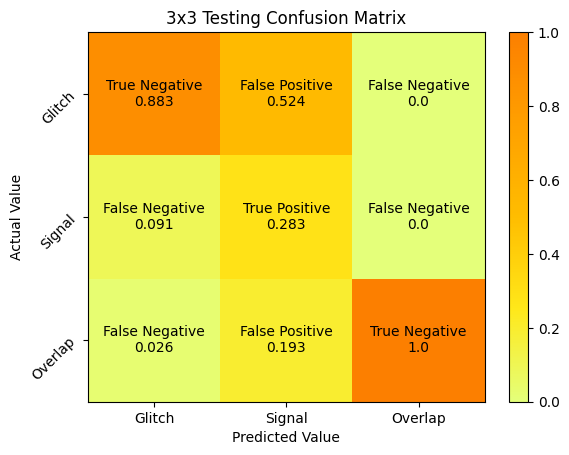

In [19]:
num_classes = 3
conf_matrix = torch.zeros([num_classes,num_classes]).to(device)
num_count = torch.zeros([num_classes]).to(device)

with torch.no_grad():
    for num, (x, y) in enumerate(tqdm(testing_data)):
        
        Real_label = y.to(device)

        # Convert sofmax output to onehot
        max_class = torch.Tensor.argmax(GASF_Model(x.to(device)), axis=1)
        pred = F.one_hot(max_class)

        # Accumlating statical value
        conf_matrix += torch.matmul(pred.T.type(dtype), Real_label.type(dtype))
        num_count += Real_label.sum(axis=0)

    print(num_count)
    num_count = num_count.detach().cpu().numpy().astype('float64')
    conf_matrix = conf_matrix.detach().cpu().numpy().astype('float64')

    
# Normalize the confusion matrix.
conf_matrix /= num_count

# print(conf_matrix)

# TODO Old confusion matrix code, not needed?
# Plotting Scheme
# TPR = conf_matrix[0, 0]
# FPR = conf_matrix[0,1]/(conf_matrix[0,0] + conf_matrix[0,1])

   
# print(f'TPR: {TPR}')
# print(f'FPR: {FPR}')

# Labels for a 3x3 confusion matrix
lab = np.array([['True Negative', 'False Positive', 'False Negative'], 
                ['False Negative', 'True Positive', 'False Negative'],
                ['False Negative', 'False Positive', 'True Negative']])

plt.figure()
color = plt.pcolormesh([conf_matrix[2], conf_matrix[1], conf_matrix[0]], cmap = 'Wistia', vmin=0, vmax=1)

# Adjust the loop for a 3x3 matrix
for i in range(3):
    for j in range(3):
        plt.text(i+.5, j+.5, 
                 f'{lab[2-j, i]}\n{round(conf_matrix[2-j, i], 3)}', 
                 ha='center', 
                 va='center')

# Update the ticks for three classes
plt.xticks([.5, 1.5, 2.5], ['Glitch', 'Signal', 'Overlap'])
plt.yticks([.5, 1.5, 2.5], ['Overlap', 'Signal', 'Glitch'], rotation=45)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('3x3 Testing Confusion Matrix')
# plt.title(
#     f'Training set with:     TPR: {round(conf_matrix[0, 0], 3)}FAR: {round(FPR, 3)}'
# )
plt.colorbar(color)
# # plt.savefig('Validation set performance.png', bbox_inches = 'tight')
plt.show()
plt.close()
